In [1]:
import keras
import numpy as np
from keras.models import Model
from keras.datasets import mnist

import keras.backend as K
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 3)

In [3]:
total_images = np.load('../q1/data/images.npy')
total_label = np.load('../q1/data/labels.npy')

In [4]:
print(total_images.shape)
total_images=total_images/255

(96000, 28, 28, 3)


In [5]:
n=total_images.shape[0]
total_labels = np.zeros(shape=(n, 96), dtype=float)
#one hot encodeing
for i,t in enumerate(total_label):
    n2 = int(48*t[0]+24*t[1]+t[2]*2+int(t[3]))
    total_labels[i][n2] = 1

print(total_labels.shape)

(96000, 96)


In [6]:
model = keras.models.load_model("Line_CNN")

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 50)        7400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6050)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              6196224   
_________________________________________________________________
dense_2 (Dense)              (None, 96)                98400     
Total params: 6,302,224
Trainable params: 6,302,124
Non-trainable params: 100
________________________________________________________________

In [8]:
layer_outputs = [layer.output for layer in model.layers[:3]]

In [9]:
layer_outputs

[<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 22, 22, 50) dtype=float32>,
 <tf.Tensor 'batch_normalization_1/cond/Merge:0' shape=(?, 22, 22, 50) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 11, 11, 50) dtype=float32>]

In [10]:
img_1 = total_images[1:2]
img_2 = total_images[2:3]
img_3 = total_images[3:4]
img_4 = total_images[4:5]
img_5 = total_images[5:6]
img_6 = total_images[6:7]

In [11]:
img_1.shape

(1, 28, 28, 3)

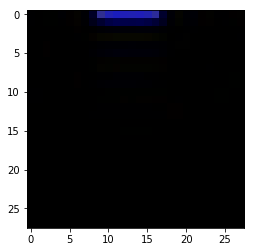

In [12]:
imgplot = plt.imshow(img_1[0])
plt.show()

In [13]:
print(total_label[1000])


[0. 0. 0. 1.]


In [14]:
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [15]:
layer_names = []
for layer in layer_outputs[:6]:
    layer_names.append(layer.name)

In [16]:
def LA(layer_names, img):
    images_per_row = 10
    activations = activation_model.predict(img)
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

C:\Users\Mukul Jangid\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\Mukul Jangid\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


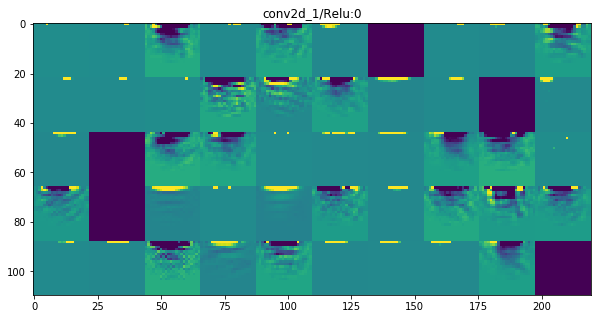

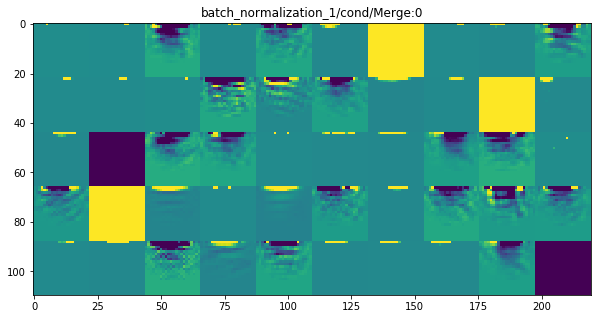

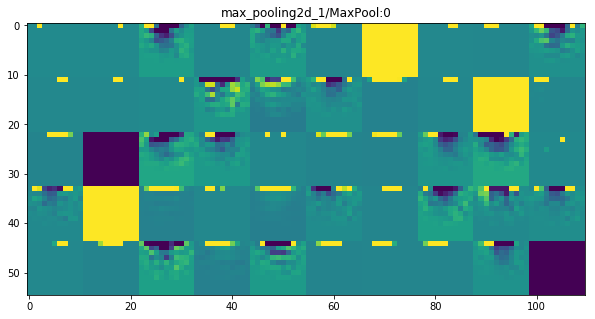

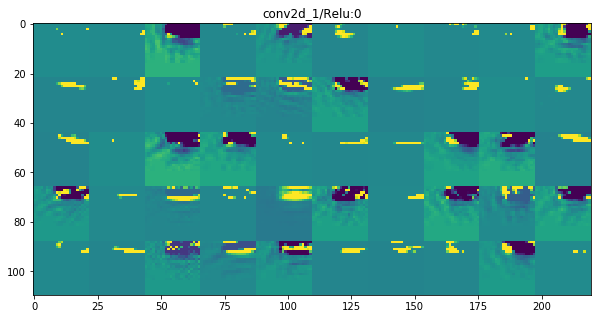

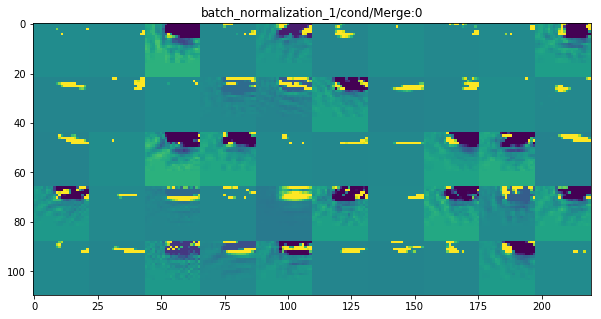

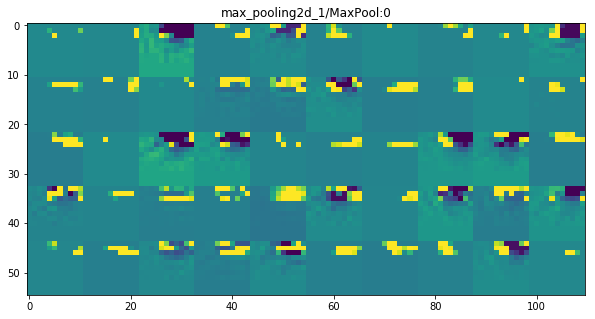

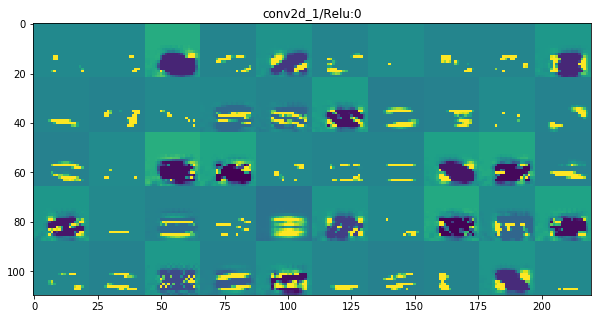

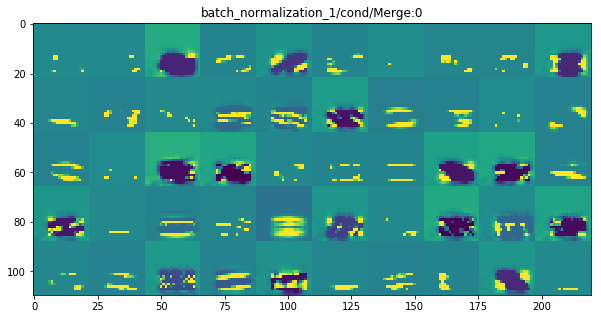

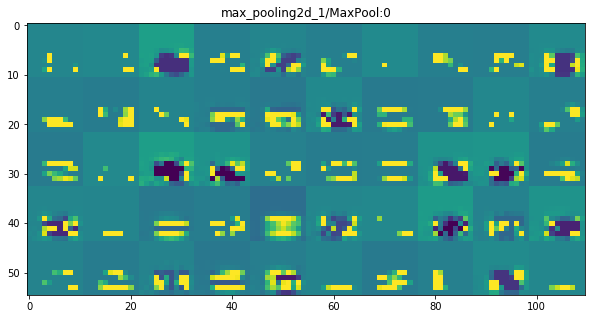

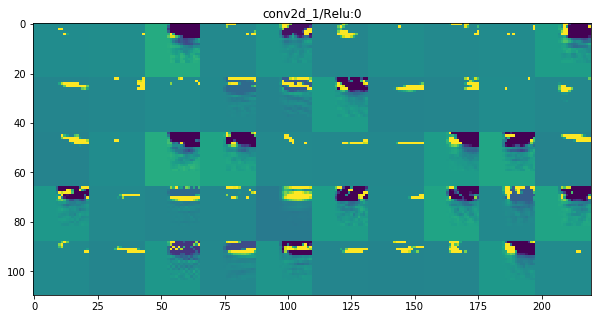

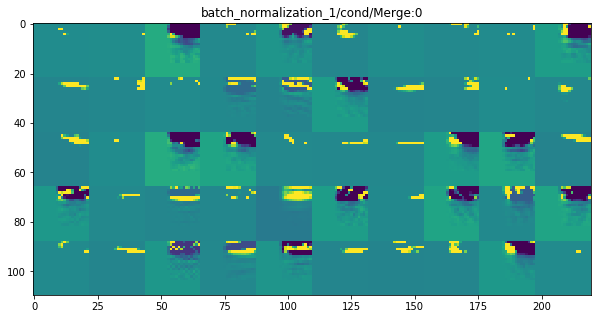

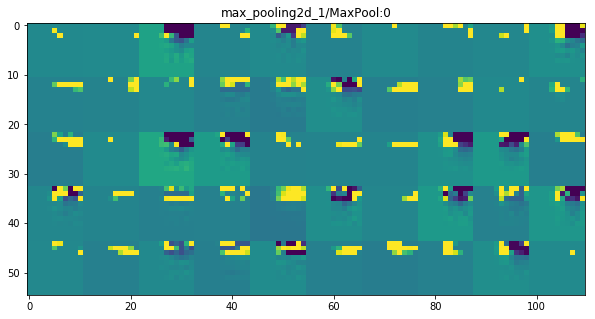

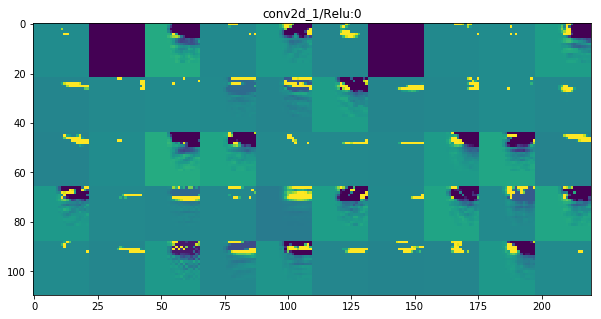

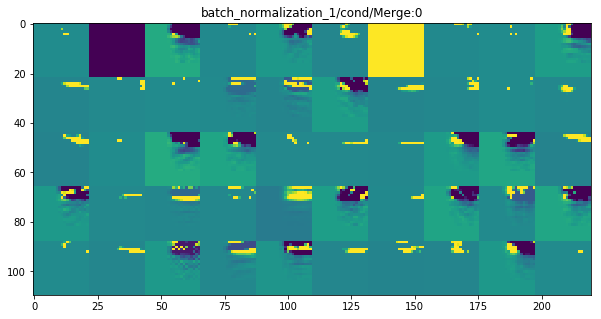

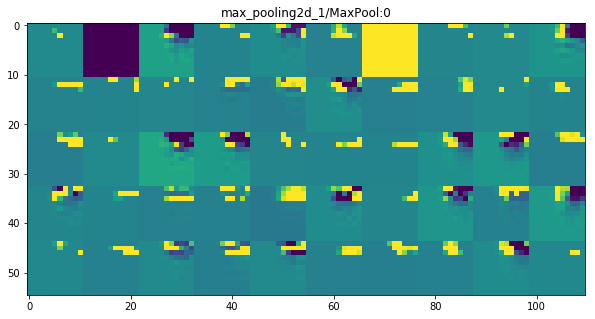

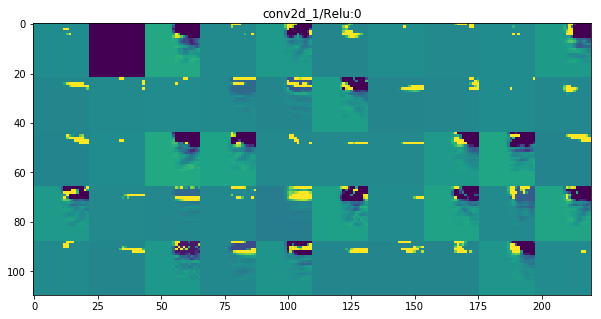

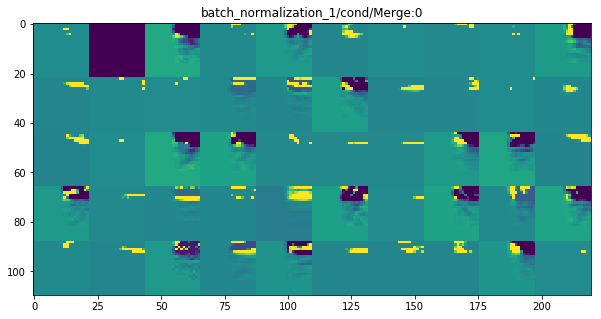

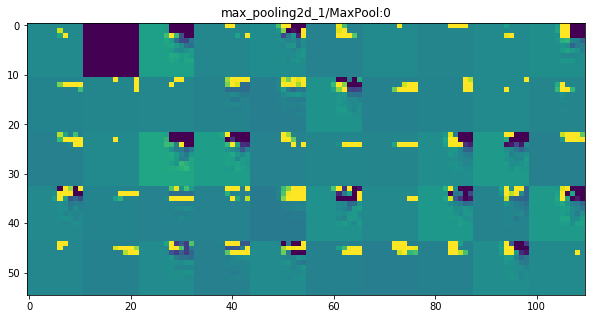

In [17]:
LA(layer_names,img_1)
LA(layer_names,img_2)
LA(layer_names,img_3)
LA(layer_names,img_4)
LA(layer_names,img_5)
LA(layer_names,img_6)

In [18]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [19]:
def layer_image(layer_name, filter_num, size):
    layer = model.get_layer(layer_name).output
    loss  = K.mean(layer[:,:,:,filter_num])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(80):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

In [20]:
layer_name = 'conv2d_1'
a = np.zeros((7,256,3), dtype=float)
for i in range(32):
    filter_img = layer_image(layer_name,i, size=7)
    a[:,i*8:i*8+7,:] = filter_img[:,:,:]
    
a=a/255

In [21]:
#for decoding
def decoder(n):
    i=int(n/48)
    j=int((n%48)/24)
    k=int(((n%48)%24)/2)
    l=int(((n%48)%24)%2)
    return i,j,k,l

[]

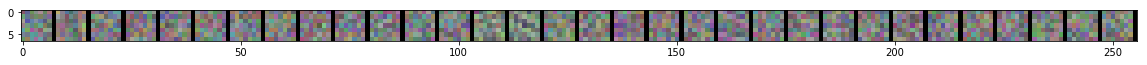

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(a)
plt.plot()

In [23]:
def Heat_Map(image,class_num):
    last_conv_layer = model.get_layer('conv2d_1')
    image_output = model.output[:,class_num]

    grads = K.gradients(image_output, last_conv_layer.output)[0]

    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([image])

    for i in range(50):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = -1* heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.imshow(heatmap)
    plt.plot()

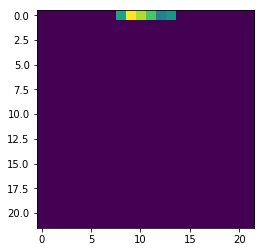

In [24]:
class_num_1=np.argmax(total_labels[1])
Heat_Map(img_1,class_num_1)


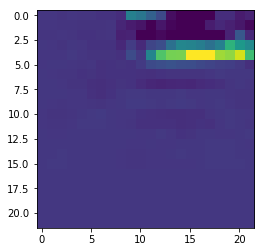

In [25]:
class_num_2=np.argmax(total_labels[2])
Heat_Map(img_2,class_num_2)

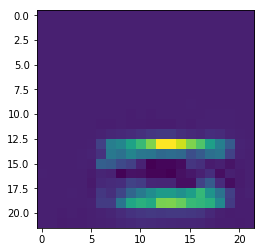

In [26]:
class_num_3=np.argmax(total_labels[3])
Heat_Map(img_3,class_num_3)

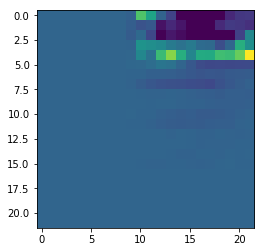

In [27]:
class_num_4=np.argmax(total_labels[4])
Heat_Map(img_4,class_num_4)

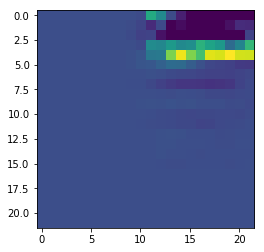

In [28]:
class_num_5=np.argmax(total_labels[5])
Heat_Map(img_5,class_num_5)


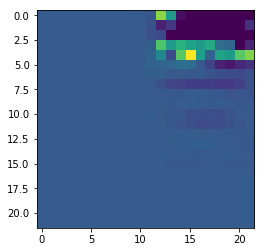

In [29]:
class_num_6=np.argmax(total_labels[6])
Heat_Map(img_6,class_num_6)